In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split  
from keras.layers import *
from keras.models import *
from keras.optimizers import Adam
from sklearn.utils import class_weight
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
import seaborn as sns

2024-09-08 12:27:57.960400: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Define the model parameters (CNN + LSTM)

In [2]:
window = 5  # Time window size for LSTM input
lstm_units = 16  # Number of LSTM units
dropout = 0.01  # Dropout rate to avoid overfitting
epochs = 200  # Number of epochs for training


# Load and preprocess data

In [3]:
df1 = pd.read_csv('merged_data.csv')

In [4]:
min_max_scaler = preprocessing.MinMaxScaler()  # Initialize MinMaxScaler for normalization
df_scaled = min_max_scaler.fit_transform(df1)  # Scale data between 0 and 1
df = pd.DataFrame(df_scaled, columns=df1.columns)

## prepare LSTM input sequences

In [5]:
seq_len = window  # Define the sequence length
data = df.values  # Extract values from the DataFrame
sequence_length = seq_len + 1  # Sequence length + 1 to include the current step
result = []

In [6]:
for index in range(len(data) - sequence_length):  
    result.append(data[index: index + sequence_length]) # Create a sliding window of sequences
result = np.array(result)  # Convert list to NumPy array


# Split the data into training and test sets

In [7]:
X = result[:, :-1]  # Input sequences
y = result[:, -1][:, -1]  # Target labels (last value of each sequence)


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)  # 80%训练集，20%测试集


## reshape data to match LSTM input requirements

In [9]:
amount_of_features = X.shape[2]

In [10]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], amount_of_features))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], amount_of_features))


## handle class imbalance by computing class weights

In [11]:
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

# Build the CNN + LSTM + Attention model

In [12]:
# input layer
inputs = Input(shape=(window, amount_of_features))

# CNN
x = Conv1D(filters=lstm_units, kernel_size=1, activation='sigmoid')(inputs)  # MaxPooling layer
x = MaxPooling1D(pool_size=window)(x)  # MaxPooling layer
x = Dropout(dropout)(x)  # Dropout layer

# LSTM 
x = Bidirectional(LSTM(lstm_units, activation='tanh'))(x)  # bi-directional LSTM layer

# Attention
attention = Dense(lstm_units * 2, activation='sigmoid')(x)  # attention mechanism
x = Multiply()([x, attention])  # attention weighting

# Output
outputs = Dense(1, activation='tanh')(x)

In [13]:
model = Model(inputs=inputs, outputs=outputs)

In [14]:
# compile the model
model.compile(loss='mse', optimizer=Adam(), metrics=['accuracy'])

In [15]:
# print model structures
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 5, 14)]              0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 5, 16)                240       ['input_1[0][0]']             
                                                                                                  
 max_pooling1d (MaxPooling1  (None, 1, 16)                0         ['conv1d[0][0]']              
 D)                                                                                               
                                                                                                  
 dropout (Dropout)           (None, 1, 16)                0         ['max_pooling1d[0][0]']   

# Train and evaluate

In [16]:
# define learning rate reduction and early stopping callbacks
lr_reduction = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.2, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


## train the model

In [17]:
history = model.fit(X_train, y_train, epochs=epochs, batch_size=1000, shuffle=False,
                    validation_data=(X_test, y_test), class_weight=class_weight_dict,
                    callbacks=[lr_reduction, early_stopping])


Epoch 1/200
2901/2901 [==============================] - 66s 21ms/step - loss: 0.0630 - accuracy: 0.9273 - val_loss: 0.0212 - val_accuracy: 0.9768 - lr: 0.0010
Epoch 2/200
2901/2901 [==============================] - 67s 23ms/step - loss: 0.0214 - accuracy: 0.9765 - val_loss: 0.0200 - val_accuracy: 0.9771 - lr: 0.0010
Epoch 3/200
2901/2901 [==============================] - 60s 21ms/step - loss: 0.0194 - accuracy: 0.9767 - val_loss: 0.0187 - val_accuracy: 0.9791 - lr: 0.0010
Epoch 4/200
2901/2901 [==============================] - 71s 24ms/step - loss: 0.0178 - accuracy: 0.9776 - val_loss: 0.0175 - val_accuracy: 0.9806 - lr: 0.0010
Epoch 5/200
2901/2901 [==============================] - 55s 19ms/step - loss: 0.0169 - accuracy: 0.9786 - val_loss: 0.0168 - val_accuracy: 0.9810 - lr: 0.0010
Epoch 6/200
2901/2901 [==============================] - 56s 19ms/step - loss: 0.0163 - accuracy: 0.9790 - val_loss: 0.0162 - val_accuracy: 0.9798 - lr: 0.0010
Epoch 7/200
2901/2901 [=================

## evaluate the model

In [18]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy:.4f}')

22661/22661 [==============================] - 32s 1ms/step - loss: 0.0102 - accuracy: 0.9835
Test Accuracy: 0.9835


## save results

In [25]:
model.save('cnn_lstm_attention_model.keras')
print("'cnn_lstm_attention_model.keras' Saved!")

'cnn_lstm_attention_model.keras' Saved!


# Visualiza model performance

## training and validation loss curves

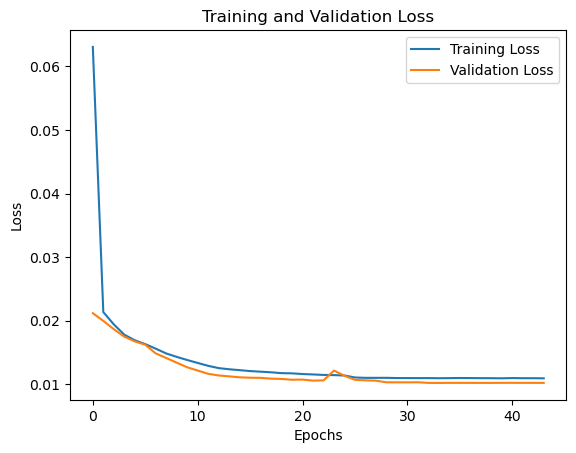

In [20]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.savefig('loss.png')
plt.show()

## training and validation loss curves

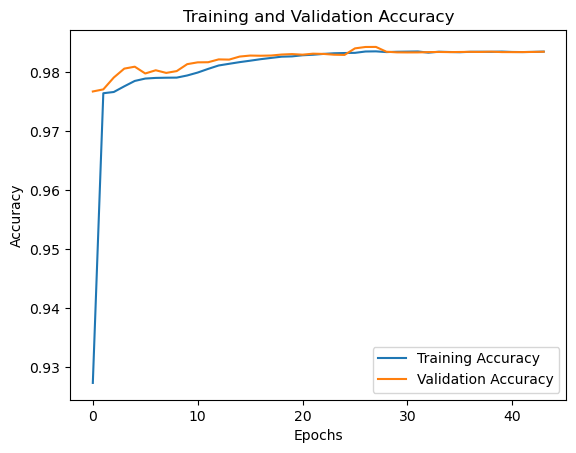

In [21]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.savefig('accuracy.png')
plt.show()

## generate predictions

In [22]:
y_pred = (model.predict(X_test) > 0.5).astype("int32")

22661/22661 [==============================] - 34s 1ms/step


## classification report

In [23]:
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99    418735
         1.0       0.98      0.98      0.98    306396

    accuracy                           0.98    725131
   macro avg       0.98      0.98      0.98    725131
weighted avg       0.98      0.98      0.98    725131



## plot confusion matrix

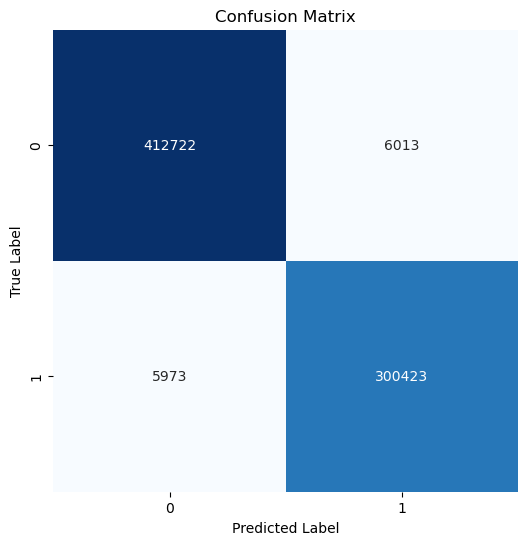

In [24]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.savefig('confusion.png')
plt.show()